<a href="https://colab.research.google.com/github/AmazingK2k3/Over_Squashing_GNNs/blob/main/MUTAG_GraphSAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
pip install -q torch-geometric

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import networkx as nx
import pandas as pd
import torch
import numpy as np
import os
import random
import sklearn
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight


import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import global_max_pool
from torch.nn import Sequential, Linear, ReLU


from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader



In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Loading MUTAG Dataset



*  1 indicates mutagenicity (causing genetic mutation)
*   0 indicates no mutagenicity




## Parameters of the PyG data object
:
x (torch.Tensor, optional) – Node feature matrix with shape [num_nodes, num_node_features]. (default: None)

edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]. (default: None)

edge_attr (torch.Tensor, optional) – Edge feature matrix with shape [num_edges, num_edge_features]. (default: None)

y (torch.Tensor, optional) – Graph-level or node-level ground-truth labels with arbitrary shape. (default: None)



In [ ]:
from torch_geometric.datasets import TUDataset

mutag = TUDataset(root = 'Over_Squashing_GNNs/data/Mutag', name = 'MUTAG')
print("len:", len(mutag))
print("num_classes:", mutag.num_classes)
print("num_node_features:", mutag.num_node_features)

len: 188
num_classes: 2
num_node_features: 7


## Nodes and Node Feature size

In [ ]:
example = mutag[0]
y = example.x.shape  #([number of nodes, num_node_features])
print(y[0], y[1])

17 7


In [ ]:
for i in range(len(mutag)):
  x = mutag[i]
  if x.y.size(0) == 0:
    print(x)
# to check if all labels exist

In [ ]:
mutag[18]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])

## Visualization of Bridges

Graph 1
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


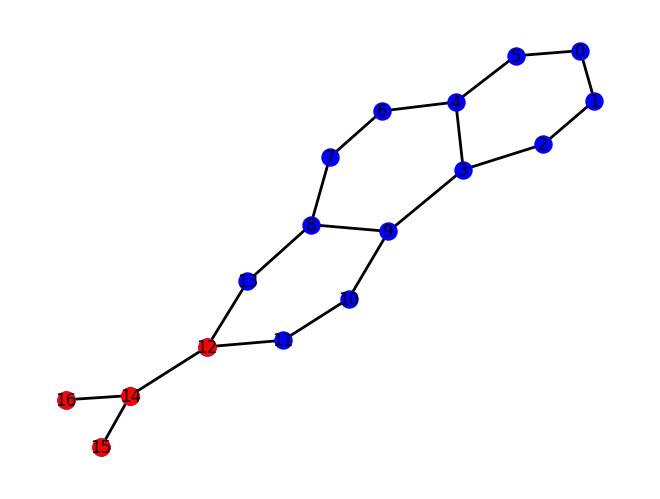

Graph 2
Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


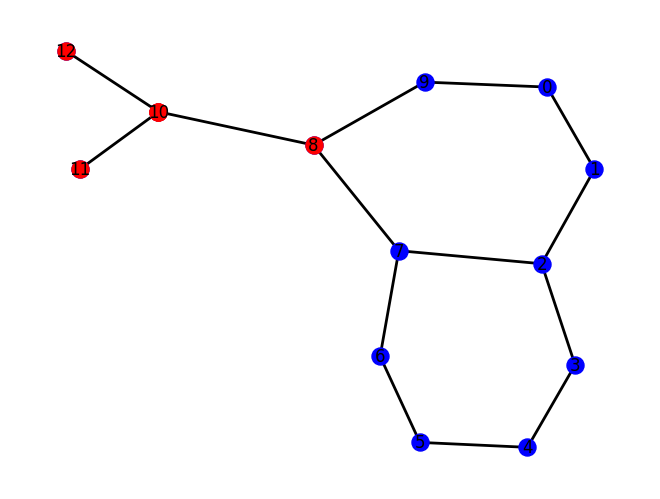

Graph 3
Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


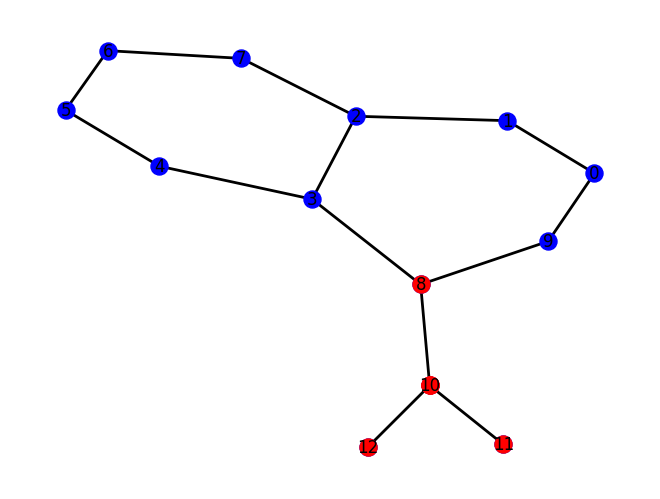

Graph 4
Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


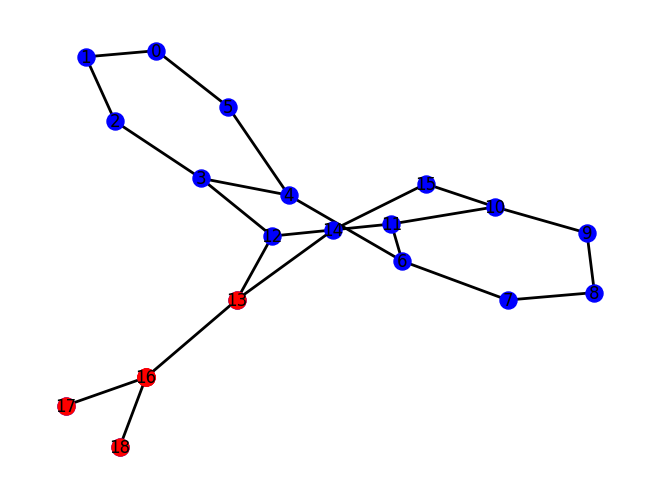

Graph 5
Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


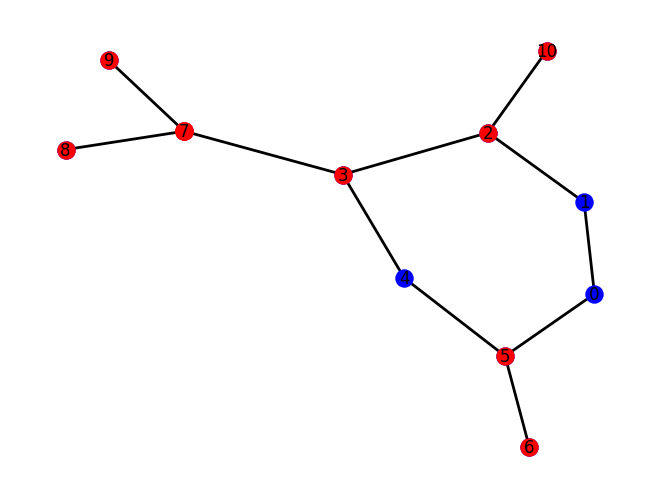

Graph 6
Data(edge_index=[2, 62], x=[28, 7], edge_attr=[62, 4], y=[1])


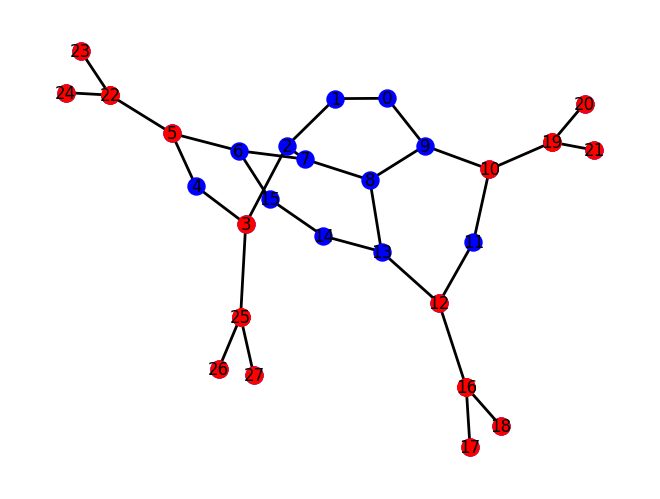

Graph 7
Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


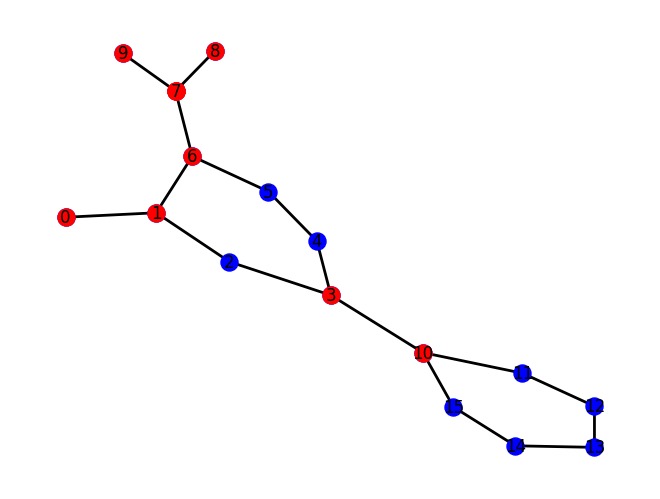

Graph 8
Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1])


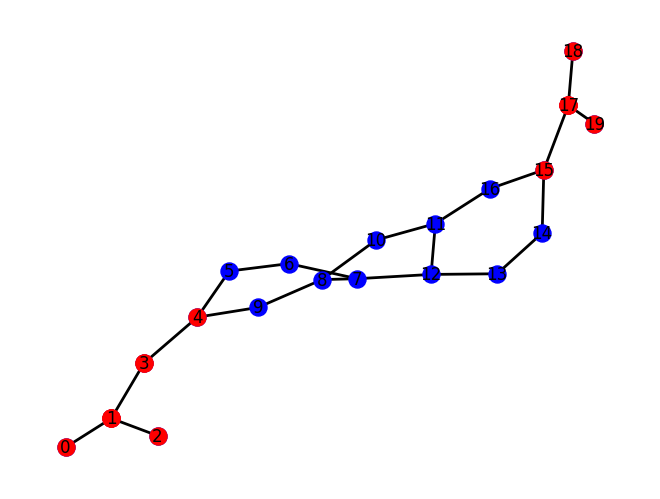

Graph 9
Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


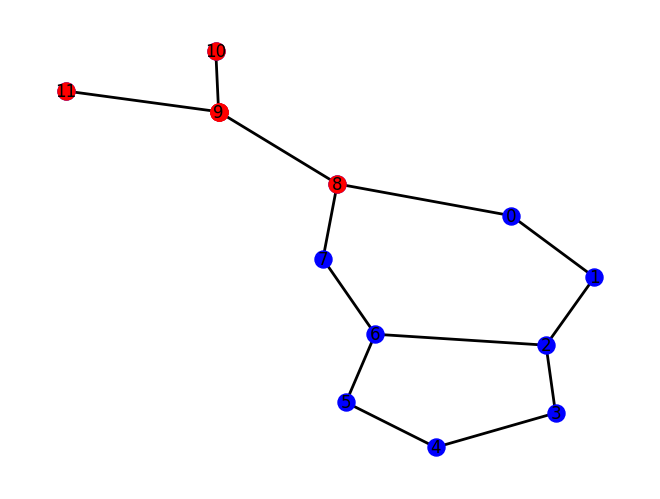

Graph 10
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


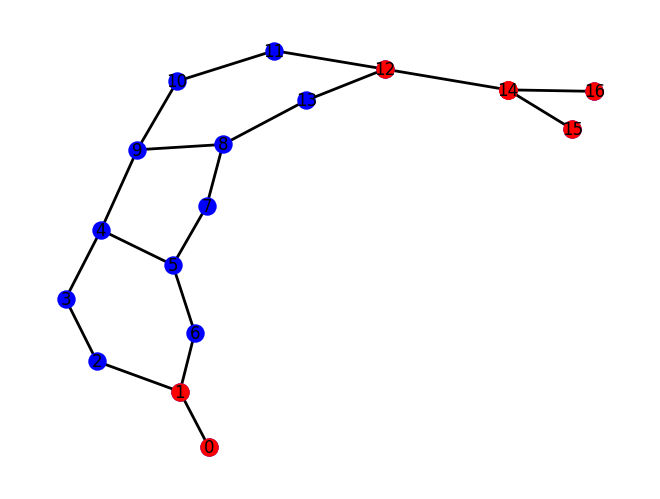

In [ ]:
for i in range(10):
  data = mutag[i]
  G = to_networkx(data,to_undirected = True)
  pos = nx.spring_layout(G)
  nx.draw(G, pos, node_color = 'blue', edge_color = 'black',
          node_size = 150, width = 2, with_labels = True)
  bridges = nx.bridges(G)
  print(f"Graph {i+1}")
  for bridge in bridges:
    nx.draw_networkx_nodes(G, pos, nodelist = bridge, node_color = 'red', node_size = 150)
  print(data)
  plt.show()

Graph 1
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


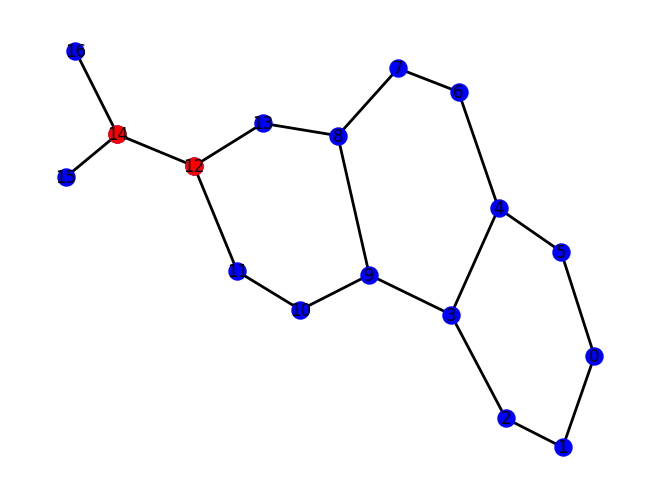

Graph 2
Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


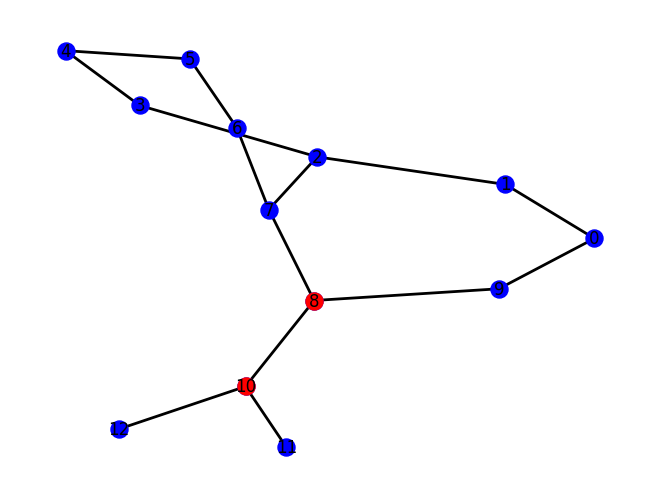

Graph 3
Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


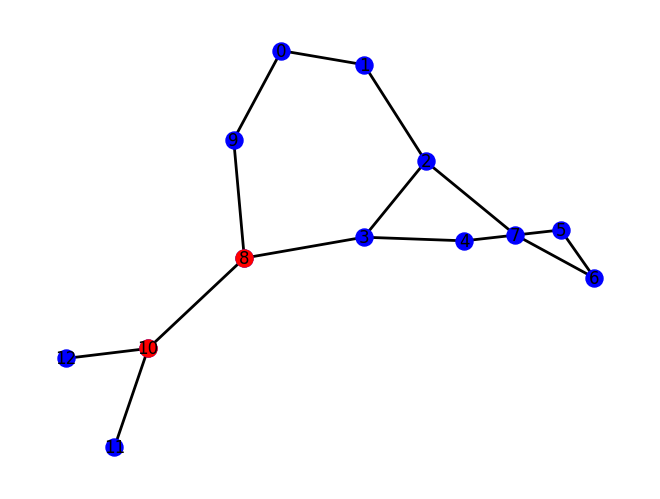

Graph 4
Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


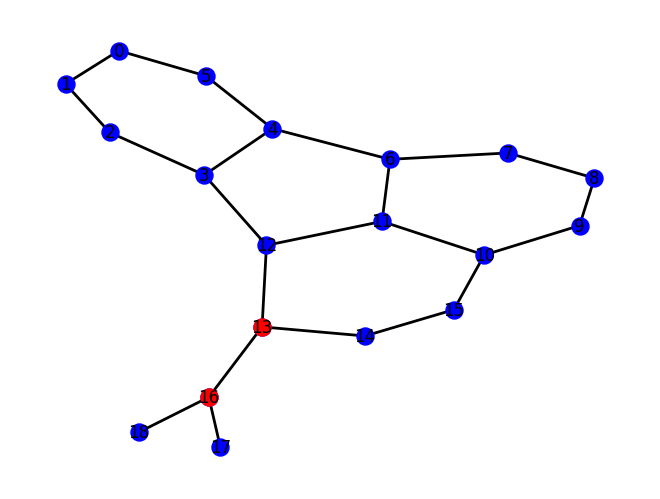

Graph 5
Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


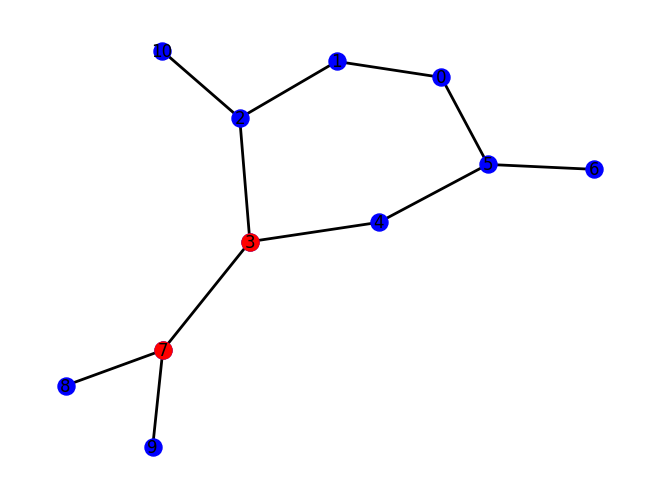

Graph 6
Data(edge_index=[2, 62], x=[28, 7], edge_attr=[62, 4], y=[1])


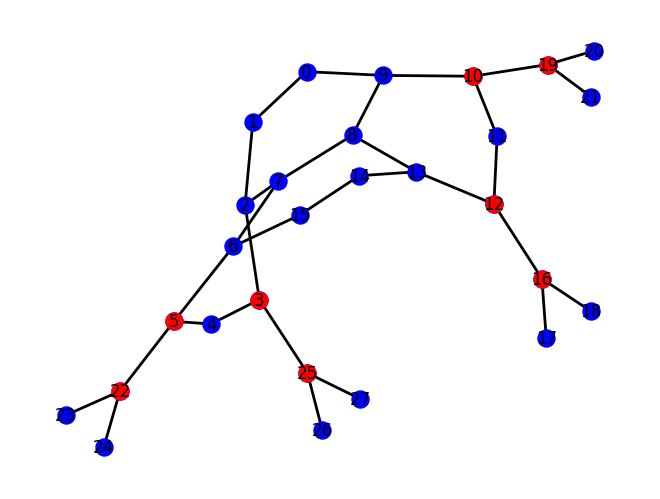

Graph 7
Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


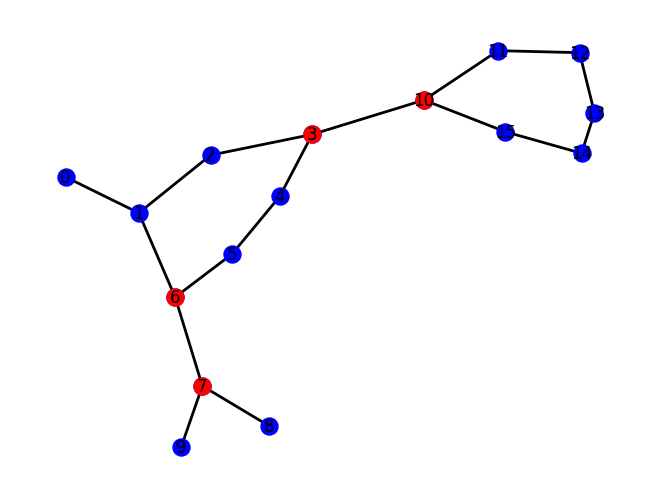

Graph 8
Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1])


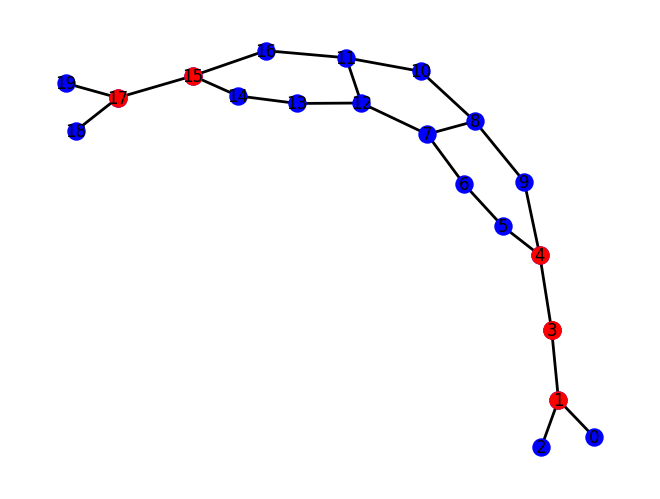

Graph 9
Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


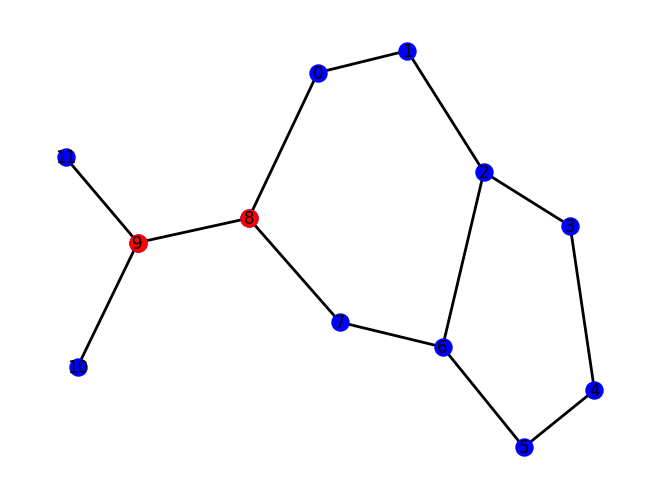

Graph 10
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


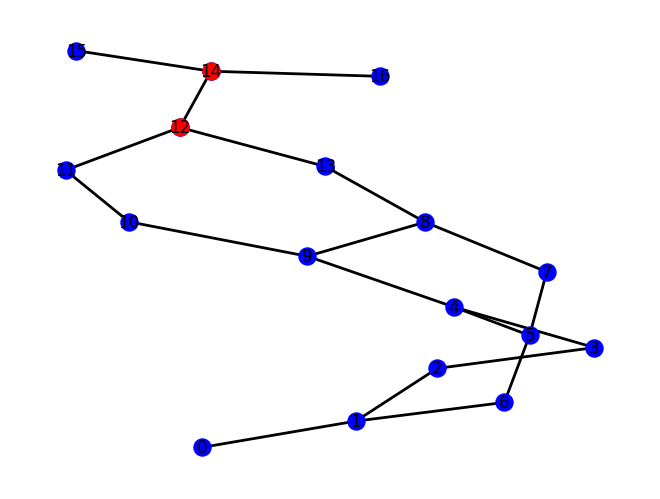

In [ ]:
# Considering only Bridges where the neighbours of bridges nodes are connected to more nodes than bridges nodes
for i in range(10):
  data = mutag[i]
  G = to_networkx(data,to_undirected = True)
  pos = nx.spring_layout(G)
  nx.draw(G, pos, node_color = 'blue', edge_color = 'black',
          node_size = 150, width = 2, with_labels = True)
  bridges = nx.bridges(G)
  print(f"Graph {i+1}")
  for bridge in bridges:
    if len(list(G.neighbors(bridge[0]))) > 1 and len(list(G.neighbors(bridge[1]))) > 1:
      nx.draw_networkx_nodes(G, pos, nodelist = bridge, node_color = 'red', node_size = 150)
  print(data)
  plt.show()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Rewiring:

## Rewire1:
### - rewires all the adjacent nodes of the bridges

In [ ]:
def rewire1(data): # this connects all the adjacent nodes of the bridges together(no triangular rewiring)
  g6 = to_networkx(data, to_undirected = True)
  bridges = list(nx.bridges(g6))

  adj_node_dict = {}
# Get all neighbors for each bridge node
  for u, v in bridges:
      for node in (u, v):
          adj_nodes = list(nx.all_neighbors(g6, node))
          adj_node_dict[node] = adj_nodes

  adj_node_dict = {key: value for key, value in adj_node_dict.items() if len(value) > 1}


 # Rewire nodes by connecting neighbors of each bridge node
  for u, v in bridges:
    neighbors_u = adj_node_dict.get(u,[])
    neighbors_v = adj_node_dict.get(v,[])

    for node_u in neighbors_u:
      for node_v in neighbors_v:
        if not g6.has_edge(node_u, node_v): # if the edge does not already exist
          g6.add_edge(node_u, node_v) # add the edge

      # Create edge_index tensor directly from edge
    edges = list(g6.edges())
    edge_index = torch.tensor(edges, dtype=torch.long).t()

    # Make undirected by adding reverse edges
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

    # Remove duplicate edges and sort
    edge_index = torch.unique(edge_index, dim=1)

    # Ensure contiguous memory layout
    edge_index = edge_index.contiguous()

  return edge_index.to(device)



In [ ]:
edge_index1 = [rewire1(mutag[i]) for i in range(len(mutag))]

In [ ]:
# run rewire for all graphs in MUTAG
print(edge_index1[0])
print(len(edge_index1))

tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 11, 12, 12, 12, 13, 13, 13,
         13, 14, 14, 14, 15, 15, 15, 16, 16, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
          7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 15, 16, 11, 13, 14,  8, 12, 15,
         16, 12, 15, 16, 11, 13, 14, 11, 13, 14]])
188


## Rewire 2:
### Connecting the adjacent nodes to the other bridge node

In [ ]:
def rewire2(data):
    g6 = to_networkx(data, to_undirected=True)
    bridges = list(nx.bridges(g6))
    adj_node_dict = {}
    #print(bridges)

    filtered_bridges = [bridge for bridge in bridges
                        if len(list(g6.neighbors(bridge[0]))) > 1 and
                        len(list(g6.neighbors(bridge[1]))) > 1]
    #print(filtered_bridges)

    # Get all neighbors for each bridge node
    for u, v in filtered_bridges:
        for node in (u, v):
            adj_nodes = list(nx.all_neighbors(g6, node))
            adj_node_dict[node] = adj_nodes

    # Filter to only include nodes with more than one neighbor
    adj_node_dict = {key: value for key, value in adj_node_dict.items() if len(value) > 1}
    keys = set(adj_node_dict.keys())

    for key, values in adj_node_dict.items():
      # Remove any bridge node found in the list
      adj_node_dict[key] = [v for v in values if v not in keys]

    for u, v in filtered_bridges: # 17,18
        neighbors_u = adj_node_dict.get(u, []) # 18, 19
        neighbors_v = adj_node_dict.get(v, []) #
        #print(f"Bridge ({u}, {v}): Neighbors of {u}: {neighbors_u}, Neighbors of {v}: {neighbors_v}")
        # Only connect each neighbor of u to v, without connecting neighbors to each other
        for node_u in neighbors_u:
            if node_u != v and not g6.has_edge(node_u, v):  # Ensure we only connect to v

                g6.add_edge(node_u, v)

        # Only connect each neighbor of v to u, without connecting neighbors to each other
        for node_v in neighbors_v:
            if node_v != u and not g6.has_edge(node_v, u):  # Ensure we only connect to u
                g6.add_edge(node_v, u)

    adj_matrix = nx.adjacency_matrix(g6).toarray()
    # function should return the edge_index

    edge_index = torch.tensor(adj_matrix, dtype=torch.long)


    edge_index = edge_index.nonzero().t().contiguous() # (2,num_edges) format and contigous memory.



    return edge_index.to(device)


In [ ]:
edge_index2 = [rewire2(mutag[i]) for i in range(len(mutag))]


In [ ]:
print(edge_index2[0])
print(len(edge_index2))

tensor([[ 0,  1,  1,  1,  2,  2,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  0,  2,  6,  1,  3,  2,  4,  3,  5,  9,  4,  6,  7,  1,  5,  5,  8,
          7,  9, 13,  4,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
         14, 14]])
188


In [ ]:
#check if edge_index1 is a tensor
print(edge_index.shape)

torch.Size([2, 38])


## Rewire 3:

### Combines rewire1 and rewire2

In [ ]:
def rewire_combined(data):
    g = to_networkx(data, to_undirected=True)
    g6 = g.copy()


    bridges = list(nx.bridges(g6))
    adj_node_dict = {}


    filtered_bridges = [bridge for bridge in bridges
                        if len(list(g6.neighbors(bridge[0]))) > 1 and
                        len(list(g6.neighbors(bridge[1]))) > 1]


    for u, v in filtered_bridges:
        for node in (u, v):
            adj_nodes = list(nx.all_neighbors(g6, node))
            adj_node_dict[node] = adj_nodes


    adj_node_dict = {key: [v for v in value if len(value) > 1 and v not in adj_node_dict]
                     for key, value in adj_node_dict.items()}


    for u, v in filtered_bridges:
        neighbors_u = adj_node_dict.get(u, [])
        neighbors_v = adj_node_dict.get(v, [])


        for node_u in neighbors_u:
            if node_u != v and not g6.has_edge(node_u, v):
                g6.add_edge(node_u, v)
        for node_v in neighbors_v:
            if node_v != u and not g6.has_edge(node_v, u):
                g6.add_edge(node_v, u)


        for node_u in neighbors_u:
            for node_v in neighbors_v:
                if node_u != node_v and not g6.has_edge(node_u, node_v):
                    g6.add_edge(node_u, node_v)

        adj_matrix = nx.adjacency_matrix(g6).toarray()
        # function should return the edge_index

        edge_index = torch.tensor(adj_matrix, dtype=torch.long)

        edge_index = edge_index.nonzero().t().contiguous() # (2,num_edges) format and contigous memory.



    return edge_index.to(device)


In [ ]:
edge_index3 = []
for i in range(len(mutag)):
  data = mutag[i]
  edge_index = rewire_combined(data)
  edge_index3.append(edge_index)

In [ ]:
print(edge_index3[0])
print(len(edge_index3))

tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12,
         13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
          7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 14, 15, 16, 11, 13, 14, 15, 16,
          8, 12, 14, 15, 16, 11, 12, 13, 15, 16, 11, 12, 13, 14, 11, 12, 13, 14]])
188


### GraphSAGE with normal wiring


In [ ]:
# GraphSage_simple model for mutag dataset - test
class GraphSage_simple(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GraphSage_simple, self).__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))
        self.linear = nn.Linear(hidden_channels, out_channels)


    def forward(self, x, edge_index, batch=None):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.linear(x)
        return torch.sigmoid(x)

In [ ]:
num_node_features = 7
# num_node_features is the number of node features.

# from binascii import a2b_hex

# from torch_geometric.nn import SAGEConv
# import itertools
# edges = list(itertools.permutations(range(18),2))
# full_adj = torch.tensor(edges,dtype = torch.long).t().contiguous().to(device)
class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()

        self.batch_norm1 = BatchNorm1d(dim_h)
        self.batch_norm2 = BatchNorm1d(dim_h//2)
        self.batch_norm3 = BatchNorm1d(dim_h//4)
        self.sage1 = SAGEConv(num_node_features, dim_h, aggr='mean',
            normalize=True) #7 * 128
        self.sage2 = SAGEConv(dim_h, dim_h//2, aggr='mean',
            normalize=True) #128 * 64
        self.sage3 = SAGEConv(dim_h//2, dim_h//4, aggr='mean',normalize=True) # 64 * 32
        self.lin = Linear((dim_h//4), 1)  # 64 * 1


    def forward(self, x, edge_index, batch):

#(32x64 and 32x1)
        h1 = self.sage1(x, edge_index) # 7 * 128
        h1 = self.batch_norm1(h1)
        h = F.elu(h1) # 128
        h = F.dropout(h, p=0.5, training=self.training) # 128
        h2 = self.sage2(h, edge_index) # 128 * 64
        h2 = self.batch_norm2(h2)
        h = F.elu(h2)
        h = F.dropout(h, p=0.5, training=self.training)
        h3 = self.sage3(h,edge_index) # 64 * 32
        h3 = self.batch_norm3(h3)
        h = F.elu(h3)
        h = global_mean_pool(h, batch) # 32 * 32
       # h = F.dropout(h, p=0.5, training=self.training)
        x = self.lin(h) # 32 * 1
        return torch.sigmoid(x)
        # return F.log_softmax(x, dim=1)



### GraphSAGE with Full Adjacency

In [ ]:

# num_node_features is the number of node features.

# from binascii import a2b_hex
import itertools


class GraphSAGE_FA(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.batch_norm1 = BatchNorm1d(dim_h)
        self.batch_norm2 = BatchNorm1d(dim_h//2)
        self.batch_norm3 = BatchNorm1d(dim_h//4)
        self.sage1 = SAGEConv(num_node_features, dim_h, aggr='mean',
            normalize=True) #7 * 128
        self.sage2 = SAGEConv(dim_h, dim_h//2, aggr='mean',
            normalize=True) #128 * 64
        self.sage3 = SAGEConv(dim_h//2, dim_h//4, aggr='mean',normalize=True) # 64 * 32
        self.lin = Linear((dim_h//4), 1)  # 32 * 1

    def forward(self, x, edge_index, batch):

        h1 = self.sage1(x, edge_index) # 7 * 128
        h1 = self.batch_norm1(h1)
        h = F.elu(h1) # 128
        h = F.dropout(h, p=0.5, training=self.training) # 128
        h2 = self.sage2(h, edge_index) # 128 * 64
        h2 = self.batch_norm2(h2)
        h = F.elu(h2)
        h = F.dropout(h, p=0.5, training=self.training)

        num_nodes = x.size(0)
        full_edges = torch.combinations(torch.arange(num_nodes), r=2).t().contiguous()  # Generate all pairs
        full_edge_index = torch.cat([full_edges, full_edges.flip(0)], dim=1)  # Make it undirected
        full_edge_index = full_edge_index.to(h.device)

        h3 = self.sage3(h,full_edge_index) # 64 * 32
        h3 = self.batch_norm3(h3)
        h = F.elu(h3)
        h = global_max_pool(h, batch) # 32 * 32
       # h = F.dropout(h, p=0.5, training=self.training)
        x = self.lin(h) # 32 * 1
        return torch.sigmoid(x)
        # return F.log_softmax(x, dim=1)




tensor([[ 0,  0,  0,  ..., 30, 31, 31],
        [ 1,  2,  3,  ..., 29, 29, 30]])

### GraphSAGE with Locally FA - Rewire Model

In [ ]:
class GraphSAGE_Rewire(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.batch_norm1 = BatchNorm1d(dim_h)
        self.batch_norm2 = BatchNorm1d(dim_h//2)
        self.batch_norm3 = BatchNorm1d(dim_h//4)

        self.sage1 = SAGEConv(num_node_features, dim_h, aggr='mean',normalize=True) #7 * 128
        self.sage2 = SAGEConv(dim_h, dim_h//2, aggr='mean',normalize=True) #128 * 64
        self.sage3 = SAGEConv(dim_h//2, dim_h//4, aggr='mean',normalize=True) # 64 * 32

        self.lin = Linear((dim_h//4), 1)  # 32 * 1

    def forward(self, x, edge_index, batch, rewired_edge_index):

        h1 = self.sage1(x, edge_index) # 7 * 128
        h1 = self.batch_norm1(h1)
        h = F.elu(h1) # 128
        h = F.dropout(h, p=0.5, training=self.training) # 128

        h2 = self.sage2(h, edge_index) # 128 * 64
        h2 = self.batch_norm2(h2)
        h = F.elu(h2)
        h = F.dropout(h, p=0.5, training=self.training)

        h3 = self.sage3(h,rewired_edge_index) # 64 * 32
        h3 = self.batch_norm3(h3)
        h = F.elu(h3)

        h = global_mean_pool(h, batch) # 32 * 32
        x = self.lin(h) # 32 * 1
        return torch.sigmoid(x)




## GraphSAGE with Locally FA with Concat Pooling

In [ ]:
class GraphSAGE_Rewire_v2(torch.nn.Module):

  # CHANGE THE OUTPUT DIMENSIONS OF THE LINEAR WHEN THE DIMENSION OF THE CONCATENATED TENSOR CHANGES.

    def __init__(self, dim_h):
        super().__init__()
        self.batch_norm1 = BatchNorm1d(dim_h)
        self.batch_norm2 = BatchNorm1d(dim_h//2)
        self.batch_norm3 = BatchNorm1d(dim_h//4)

        self.sage1 = SAGEConv(num_node_features, dim_h, aggr='mean',normalize=True) #7 * 128
        self.sage2 = SAGEConv(dim_h, dim_h//2, aggr='mean',normalize=True) #128 * 64
        self.sage3 = SAGEConv(dim_h//2, dim_h//4, aggr='mean',normalize=True) # 64 * 32

        self.lin = Linear(2*(dim_h//4+dim_h//2+dim_h), 1)  # 32 * 1

    def forward(self, x, edge_index, batch, rewired_edge_index):

        h1 = self.sage1(x, edge_index) #dim_h
        h1 = self.batch_norm1(h1)
        h = F.elu(h1) # 128
        h = F.dropout(h, p=0.5, training=self.training) # 128

        h2 = self.sage2(h, edge_index) # dim_h/2
        h2 = self.batch_norm2(h2)
        h = F.elu(h2)
        h = F.dropout(h, p=0.5, training=self.training)

        h3 = self.sage3(h,rewired_edge_index) # dim/4
        h3 = self.batch_norm3(h3)
        h = F.elu(h3)

        a3 = global_mean_pool(h, batch) # 16
        a1 = global_mean_pool(h1,batch) # 64
        a2 = global_mean_pool(h2,batch) # 32


        # Dimension of torch cat is (16+64+32) = 112

        s3 = global_add_pool(h,batch)
        s1 = global_add_pool(h1,batch)
        s2 = global_add_pool(h2,batch)

        m3 = global_max_pool(h,batch)
        m1 = global_max_pool(h1,batch)
        m2 = global_max_pool(h2,batch)

        #h =  torch.cat((a1,a2,a3), dim=1)
        #h = torch.cat((s1,s2,s3),dim = 1)
        h = torch.cat((m1,m2,m3,a1,a2,a3), dim = 1)
        h = F.dropout(h, p=0.5, training=self.training)
        x = self.lin(h) # 32 * 1
        return torch.sigmoid(x)




In [ ]:
class GraphSAGE_Rewire_v3(torch.nn.Module):
    def __init__(self, dim_h, num_layers, num_classes=1):
        super().__init__()
        self.num_layers = num_layers
        
        # Create ModuleLists to store layers
        self.batch_norms = nn.ModuleList()
        self.sage_layers = nn.ModuleList()
        
        # First layer
        self.batch_norms.append(BatchNorm1d(dim_h))
        self.sage_layers.append(SAGEConv(num_node_features, dim_h, aggr='mean', normalize=True))
        
        # Middle layers
        for i in range(1, num_layers):
            dim_out = dim_h // (2 ** i)
            self.batch_norms.append(BatchNorm1d(dim_out))
            self.sage_layers.append(SAGEConv(dim_h // (2 ** (i-1)), dim_out, 
                                           aggr='mean', normalize=True))
        
        # Calculate the dimension of the concatenated tensor
        # For each layer, we'll have mean, add, and max pooling outputs
        total_concat_dim = 0
        for i in range(num_layers):
            layer_dim = dim_h // (2 ** i)
            total_concat_dim += layer_dim * 3  # multiply by 3 for mean, add, and max pooling
            
        self.lin = Linear(total_concat_dim, num_classes)
        
    def forward(self, x, edge_index, batch, rewired_edge_index):
        # Lists to store intermediate outputs
        mean_pools = []
        add_pools = []
        max_pools = []
        
        # Process through all layers except the last one using original edge_index
        h = x
        for i in range(self.num_layers - 1):
            h = self.sage_layers[i](h, edge_index)
            h = self.batch_norms[i](h)
            h = F.elu(h)
            h = F.dropout(h, p=0.5, training=self.training)
            
            # Store pooled outputs
            mean_pools.append(global_mean_pool(h, batch))
            add_pools.append(global_add_pool(h, batch))
            max_pools.append(global_max_pool(h, batch))
        
        # Last layer uses rewired_edge_index
        h = self.sage_layers[-1](h, rewired_edge_index)
        h = self.batch_norms[-1](h)
        h = F.elu(h)
        
        # Store pooled outputs for last layer
        mean_pools.append(global_mean_pool(h, batch))
        add_pools.append(global_add_pool(h, batch))
        max_pools.append(global_max_pool(h, batch))
        
        # Concatenate all pooled outputs
        h = torch.cat([*max_pools, *mean_pools, *add_pools], dim=1)
        h = F.dropout(h, p=0.5, training=self.training)
        
        # Final linear layer
        x = self.lin(h)
        
        return torch.sigmoid(x)

## Loader Function

In [ ]:
def split_data(data, train_size=0.75, val_size=0.15, random_state=42):
    # Convert to list if not already
    data = list(data)

    # First split: separate training set
    temp_data, test_data = train_test_split(
        data,
        test_size=(1-train_size),
        random_state=random_state,
        shuffle=True,
        stratify=[d.y for d in data]
    )

    # Second split: separate validation from test
    # Calculate relative validation size
    relative_val_size = val_size / (1-train_size)
    train_data, val_data = train_test_split(
        temp_data,
        test_size=relative_val_size,
        random_state=random_state,
        shuffle=True,
        stratify=[d.y for d in temp_data]

    )

    return train_data, val_data, test_data


In [ ]:
from torch_geometric.loader import DataLoader


def loader(data, batch_size):
    # for data in data:
    #     data.sort(sort_by_row=False)

    train_data, val_data, test_data = split_data(data)
    #Below used for sorting the edge_index but not working
    # def sort_edge_index(data_list):
    #     for data in data_list:
    #         data.sort(sort_by_row=False)
    #     return data_list

    # train_data = sort_edge_index(train_data)
    # val_data = sort_edge_index(val_data)
    # test_data = sort_edge_index(test_data)


    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=True  # No need to shuffle validation
    )
    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle test
    )

    return train_loader, val_loader, test_loader


## Result Functions


In [ ]:

def Roc_curve(labels, preds, model_name):
  fpr, tpr, thresholds = roc_curve(labels, preds)
  plt.figure(figsize = (4,4))
  plt.plot(fpr, tpr)
  plt.title(f"{model_name}")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])


In [ ]:
def save_classification_report_txt(report_str, model_name, file_path):
    with open(file_path, 'w') as f:
        f.write(f"Classification Report for {model_name}:\n")
        f.write(report_str)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

def Confusion_matrix(confmat, model_name):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Not Mutagenic', 'Mutagenic'])
    ax.set_yticklabels(['Not Mutagenic', 'Mutagenic'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f"{model_name}")
    plt.tight_layout()
    plt.show()

def c_matplot(model, test_loader, j, rewired_edge_index= None):
    all_labels = []
    all_preds = []
    model_name = type(model).__name__
    #model.eval()
    #with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
        data.x = data.x.to(device)
        data.edge_index = data.edge_index.to(device)
        data.batch = data.batch.to(device)
        data.y = data.y.to(device)
        if rewired_edge_index:
            out = model(data.x, data.edge_index, data.batch, rewired_edge_index[batch_idx])
        else:
            out = model(data.x, data.edge_index, data.batch)
        out = out.squeeze()
        out = (out >= 0.5).int()
        out = out.view(-1).detach().cpu().numpy()
        all_labels.extend(data.y.cpu().numpy())
        all_preds.extend(out)

    clf_rp = classification_report(all_labels, all_preds)
    save_classification_report_txt(clf_rp, model_name, f'Over_Squashing_GNNs/models/Mutag_results/Clf_reports_mutag_Gs/exp{j}_{model_name}.txt')
    conf = confusion_matrix(y_true=all_labels, y_pred=all_preds)
    roc_curve = Roc_curve(all_labels, all_preds, model_name)
    return Confusion_matrix(conf, model_name), print(clf_rp), roc_curve

### Training Loop -1

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def train_1(model, loader, lr, epochs,i, rewired_edge_index=None):
  # all_labels = []
  # for data in loader:
  #     all_labels.extend(data.y.cpu().numpy())
  # class_weights = compute_class_weight('balanced', classes=[0, 1], y=all_labels)
  # weights = torch.tensor(class_weights, dtype=torch.float).to(device)


  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=0.01)
  epochs = epochs
  model.train()

  train_accuracies = []
  val_accuracies = []
  best_val_acc = 0
  best_model_state = None
  for epoch in range(epochs+1):
    total_loss = 0
    acc = 0
    val_loss = 0
    val_acc = 0

    for batch_idx, data in enumerate(train_loader):
      data.x = data.x.to(device)
      data.edge_index = data.edge_index.to(device)
      data.y = data.y.to(device).float()
      data.batch = data.batch.to(device)
      #data.y = data.y.view(-1,1)

      optimizer.zero_grad()
       # Handle rewired edge index if present
      if rewired_edge_index is not None:
          out = model(data.x, data.edge_index, data.batch, rewired_edge_index=rewired_edge_index[batch_idx])
      else:
          out = model(data.x, data.edge_index, data.batch)
      out = out.view(-1)

      #print("Before view", out)
      loss = criterion(out, data.y)
      total_loss += loss/ len(loader)
      acc += accuracy(out, data.y)/len(loader)
      loss.backward()
      optimizer.step()

    val_loss, val_acc = test(model, val_loader, rewired_edge_index=rewired_edge_index if rewired_edge_index is not None else None)
    val_acc = round(val_acc,2)
    #print("val_acc",val_acc)
    val_accuracies.append(val_acc)

    #print(len(train_accuracies),len(val_accuracies))
    if val_acc > best_val_acc:
      best_val_acc = val_acc
      best_train_acc = acc
      best_epoch = epoch
      best_model_state = model.state_dict()

   # print("best_val_acc",best_val_acc)
    train_accuracies.append(round(acc*100,2))
   # total_loss /= len(loader)
   # acc /= len(loader)


    if(epoch % 5 == 0):
      print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc:.2f}%')
    #print(len(val_accuracies), len(train_accuracies))


  model_name = type(model).__name__

  torch.save(best_model_state, f'Over_Squashing_GNNs/models/Mutag_results/best_models/exp{i}_{model_name}.pth')
  model.load_state_dict(best_model_state)

  plt.figure(figsize=(8, 5))
  plt.plot(range(epochs + 1), train_accuracies, label='Training Accuracy')
  plt.plot(range(epochs + 1), val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title(f'Training vs. Validation Accuracy of {model_name}')
  plt.show()


  #return model, best_val_acc, best_train_acc, best_epoch
  return model, round(best_train_acc * 100, 2), round(best_val_acc, 2), best_epoch
@torch.no_grad()
def test(model, loader, rewired_edge_index=None):
  criterion = torch.nn.BCELoss()
  #model.eval()
  loss = 0
  acc = 0

  for batch_idx, data in enumerate(train_loader):
    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    data.y = data.y.to(device).float()
    data.batch = data.batch.to(device)


     # Handle rewired edge index if present
    if rewired_edge_index is not None:
        out = model(data.x, data.edge_index, data.batch, rewired_edge_index=rewired_edge_index[batch_idx])
    else:
        out = model(data.x, data.edge_index, data.batch)
    #print("Output shape:", out.shape)
    #print("Target shape:", data.y.shape)

    out = out.view(-1)

    loss += criterion(out, data.y.float())/len(loader)
    acc  += accuracy(out, data.y)/len(loader)

  return loss, round(acc *100, 2)



def accuracy(pred_y, y):
  #print("Before Squeeze", pred_y)
  pred = pred_y.squeeze()
  #print("After Squeeze", pred)
  pred = (pred >= 0.5).float()
  #print("After thresholding", pred)
  return (pred == y).sum().item()/len(y)






Epoch   0 | Train Loss: 0.73 | Train Acc: 46.35% | Val Loss: 0.49 | Val Acc: 29.51%
Epoch   5 | Train Loss: 0.71 | Train Acc: 48.96% | Val Loss: 0.48 | Val Acc: 32.64%
Epoch  10 | Train Loss: 0.71 | Train Acc: 37.50% | Val Loss: 0.47 | Val Acc: 33.33%
Epoch  15 | Train Loss: 0.67 | Train Acc: 64.58% | Val Loss: 0.44 | Val Acc: 44.44%
Epoch  20 | Train Loss: 0.64 | Train Acc: 66.67% | Val Loss: 0.43 | Val Acc: 45.49%
Epoch  25 | Train Loss: 0.61 | Train Acc: 72.40% | Val Loss: 0.42 | Val Acc: 44.79%
Epoch  30 | Train Loss: 0.61 | Train Acc: 74.48% | Val Loss: 0.41 | Val Acc: 46.53%
Epoch  35 | Train Loss: 0.58 | Train Acc: 73.44% | Val Loss: 0.38 | Val Acc: 50.69%
Epoch  40 | Train Loss: 0.59 | Train Acc: 72.92% | Val Loss: 0.37 | Val Acc: 51.39%
Epoch  45 | Train Loss: 0.55 | Train Acc: 77.60% | Val Loss: 0.42 | Val Acc: 46.53%
Epoch  50 | Train Loss: 0.58 | Train Acc: 69.27% | Val Loss: 0.38 | Val Acc: 52.08%
Epoch  55 | Train Loss: 0.56 | Train Acc: 78.65% | Val Loss: 0.37 | Val Acc:

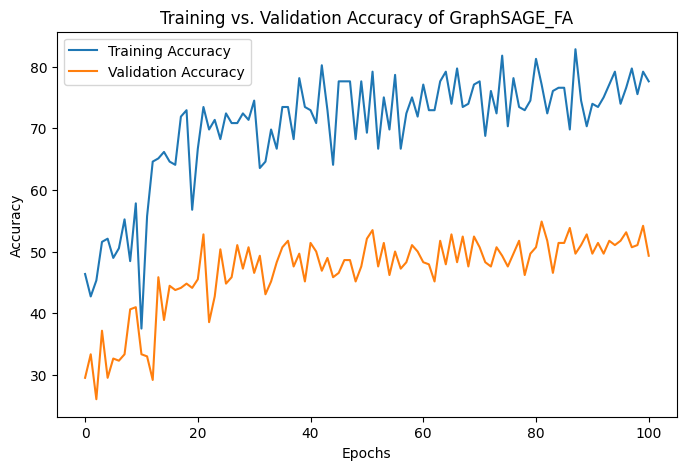

Test Loss: 0.5359944105148315 | Test Acc: 73.96%
Training Accuracy: 77.08| Validation Accuracy: 54.86| Epoch: 81


In [ ]:
import torch.nn as nn


batch_size = 32
train_loader, val_loader, test_loader = loader(mutag, batch_size = batch_size)
sage  = GraphSAGE_FA(dim_h = 128).to(device)
model = sage
#model, train_acc, val_acc, epochs = train_1(model, train_loader, lr = 0.0001, epochs = 100, i = 1)
model, train_acc, val_acc, epochs = train_1(model, train_loader, lr = 0.0001, epochs = 100, i = 1, rewired_edge_index=None)
#test_loss, test_acc = test(model, test_loader)
test_loss, test_acc = test(model, test_loader, rewired_edge_index= None)



print(f'Test Loss: {test_loss} | Test Acc: {test_acc}%')
print(f'Training Accuracy: {train_acc}| Validation Accuracy: {val_acc}| Epoch: {epochs}')


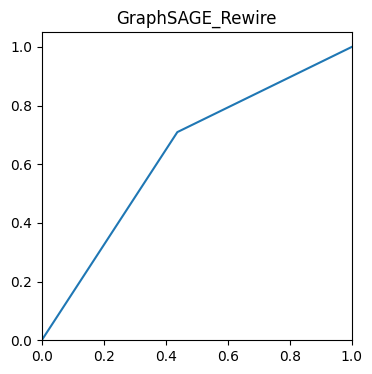

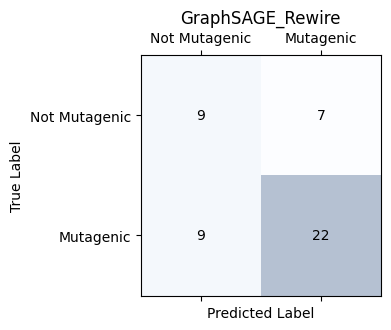

              precision    recall  f1-score   support

           0       0.50      0.56      0.53        16
           1       0.76      0.71      0.73        31

    accuracy                           0.66        47
   macro avg       0.63      0.64      0.63        47
weighted avg       0.67      0.66      0.66        47



(None, None, None)

In [ ]:
c_matplot(model, test_loader,1, rewired_edge_index= edge_index3)

### Better training Step implementation - modified - Training 2

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import f1_score, precision_recall_fscore_support
import wandb  # Optional for logging
from tqdm import tqdm
import matplotlib.pyplot as plt

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_epoch(model, loader, criterion, optimizer, device, rewired_edge_index=None):
    model.train()
    total_loss = 0
    predictions = []
    labels = []

    for batch_idx, data in enumerate(loader):
        data = data.to(device)
        # data.edge_index = data.edge_index.to(device)
        # data.y = data.y.to(device)
        # data.batch = data.batch.to(device)


        optimizer.zero_grad()

        # Forward pass
        if rewired_edge_index is not None:
            out = model(data.x, data.edge_index, data.batch, rewired_edge_index=rewired_edge_index[batch_idx]).squeeze()
        else:
            out = model(data.x, data.edge_index, data.batch).squeeze()
        # Calculate loss
        loss = criterion(out, data.y.float())
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        # Store predictions and labels
        pred = (out >= 0.5).float()
        predictions.extend(pred.cpu().numpy())
        labels.extend(data.y.cpu().numpy())

        total_loss += loss.item() * data.num_graphs

    # Calculate metrics
    avg_loss = total_loss / len(loader.dataset)
    accuracy = np.mean(np.array(predictions) == np.array(labels))
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    return avg_loss, accuracy, precision, recall, f1

@torch.no_grad()
def evaluate(model, loader, criterion, device, rewired_edge_index=None):
    model.eval()
    total_loss = 0
    predictions = []
    labels = []

    for batch_idx, data in enumerate(loader):
        data = data.to(device)
        # data.edge_index = data.edge_index.to(device)
        # data.y = data.y.to(device)
        # data.batch = data.batch.to(device)


        # Get model output and ensure correct shape
        if rewired_edge_index is not None:
            out = model(data.x, data.edge_index, data.batch, rewired_edge_index=rewired_edge_index[batch_idx]).squeeze()
        else:
            out = model(data.x, data.edge_index, data.batch).squeeze()

        # Reshape output and target to match dimensions
        if out.dim() == 0:  # Check if out is scalar
            out = out.unsqueeze(0)
        if data.y.dim() == 0:  # Check if target is scalar
            data.y = data.y.unsqueeze(0)

        # Compute loss
        loss = criterion(out, data.y.float())
        total_loss += loss.item() * data.num_graphs

        # Binarize predictions
        pred = (out >= 0.5).float()
        predictions.extend(pred.cpu().numpy())
        labels.extend(data.y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = np.mean(np.array(predictions) == np.array(labels))
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    return avg_loss, accuracy, precision, recall, f1


def train(model, train_loader, val_loader, config,i=None, rewiring_edge_index = None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Initialize training components
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([config['pos_weight']]).to(device))
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'])
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'])

    # Training tracking
    best_metrics = {
        'train': {'f1': 0, 'loss': float('inf'), 'accuracy': 0},
        'val': {'f1': 0, 'loss': float('inf'), 'accuracy': 0}
    }
    train_metrics, val_metrics = [], []

    for epoch in tqdm(range(config['epochs'])):
        # Training phase
        train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(
            model, train_loader, criterion, optimizer, device, rewired_edge_index = rewiring_edge_index if rewiring_edge_index is not None else None
        )

        # Validation phase
        val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(
            model, val_loader, criterion, device, rewired_edge_index = rewiring_edge_index if rewiring_edge_index is not None else None
        )

        # Scheduler step
        scheduler.step()

        # Early stopping check
        early_stopping(val_loss)

        # Save best model based on validation F1 score
        if val_f1 > best_metrics['val']['f1']:
            best_metrics['val'] = {
                'f1': val_f1, 'loss': val_loss, 'accuracy': val_acc
            }
            best_metrics['train'] = {
                'f1': train_f1, 'loss': train_loss, 'accuracy': train_acc
            }
            best_model_state = model.state_dict().copy()

        # Store metrics for each epoch
        train_metrics.append({'loss': train_loss, 'accuracy': train_acc, 'f1': train_f1})
        val_metrics.append({'loss': val_loss, 'accuracy': val_acc, 'f1': val_f1})

        # Optional: Log to wandb
        if config['use_wandb']:
            wandb.log({
                'train_loss': train_loss,
                'train_acc': train_acc,
                'train_f1': train_f1,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'learning_rate': optimizer.param_groups[0]['lr']
            })

        # Print metrics at intervals
        if epoch % config['print_every'] == 0:
            print(f'Epoch {epoch:03d}:')
            print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}')

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break


    # Load best model
    model.load_state_dict(best_model_state)
    print("\nBest Train Metrics:", best_metrics['train'])
    print("Best Validation Metrics:", best_metrics['val'])
    model_name = type(model).__name__
    i = i if i is not None else ''
    torch.save(best_model_state, f'Over_Squashing_GNNs/models/Mutag_results/best_models/{model_name}_rewiring_{i}.pth')




    return model, train_metrics, val_metrics, best_metrics

def plot_training_metrics(train_metrics, val_metrics):
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot([x['loss'] for x in train_metrics], label='Train Loss')
    plt.plot([x['loss'] for x in val_metrics], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot([x['accuracy'] for x in train_metrics], label='Train Accuracy')
    plt.plot([x['accuracy'] for x in val_metrics], label='Val Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot F1 score
    plt.subplot(1, 3, 3)
    plt.plot([x['f1'] for x in train_metrics], label='Train F1')
    plt.plot([x['f1'] for x in val_metrics], label='Val F1')
    plt.title('F1 Score over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()



  8%|▊         | 8/100 [00:00<00:02, 34.50it/s]

Epoch 000:
Train Loss: 0.7004, Acc: 0.7500, F1: 0.7941
Val Loss: 0.6994, Acc: 0.6471, F1: 0.7826
Epoch 005:
Train Loss: 0.6698, Acc: 0.7857, F1: 0.8286
Val Loss: 0.6885, Acc: 0.6471, F1: 0.7541


 16%|█▌        | 16/100 [00:00<00:02, 35.00it/s]

Epoch 010:
Train Loss: 0.6521, Acc: 0.7679, F1: 0.8116
Val Loss: 0.6755, Acc: 0.7059, F1: 0.7664
Epoch 015:
Train Loss: 0.6447, Acc: 0.7500, F1: 0.7941
Val Loss: 0.6619, Acc: 0.6824, F1: 0.7327


 25%|██▌       | 25/100 [00:00<00:02, 34.84it/s]

Epoch 020:
Train Loss: 0.6339, Acc: 0.7857, F1: 0.8286
Val Loss: 0.6534, Acc: 0.6706, F1: 0.7143
Epoch 025:
Train Loss: 0.6265, Acc: 0.7679, F1: 0.8060
Val Loss: 0.6472, Acc: 0.6941, F1: 0.7292


 39%|███▉      | 39/100 [00:01<00:01, 39.62it/s]

Epoch 030:
Train Loss: 0.6205, Acc: 0.7679, F1: 0.8116
Val Loss: 0.6384, Acc: 0.7059, F1: 0.7525
Epoch 035:
Train Loss: 0.6188, Acc: 0.8036, F1: 0.8451
Val Loss: 0.6361, Acc: 0.7059, F1: 0.7525


 46%|████▌     | 46/100 [00:01<00:01, 36.12it/s]

Epoch 040:
Train Loss: 0.6173, Acc: 0.7857, F1: 0.8286
Val Loss: 0.6380, Acc: 0.6941, F1: 0.7292
Epoch 045:
Train Loss: 0.6123, Acc: 0.7679, F1: 0.8116
Val Loss: 0.6374, Acc: 0.6941, F1: 0.7292
Early stopping triggered

Best Train Metrics: {'f1': 0.7941176470588235, 'loss': 0.6585333262171064, 'accuracy': 0.75}
Best Validation Metrics: {'f1': 0.7964601769911505, 'loss': 0.680325691840228, 'accuracy': 0.7294117647058823}

Best Training Metrics:
Loss: 0.6585, Accuracy: 0.7500, F1: 0.7941

Best Validation Metrics:
Loss: 0.6803, Accuracy: 0.7294, F1: 0.7965

Test Metrics:
Loss: 0.6093, Accuracy: 0.5957, F1: 0.6545, Precision: 0.7500, Recall: 0.5806


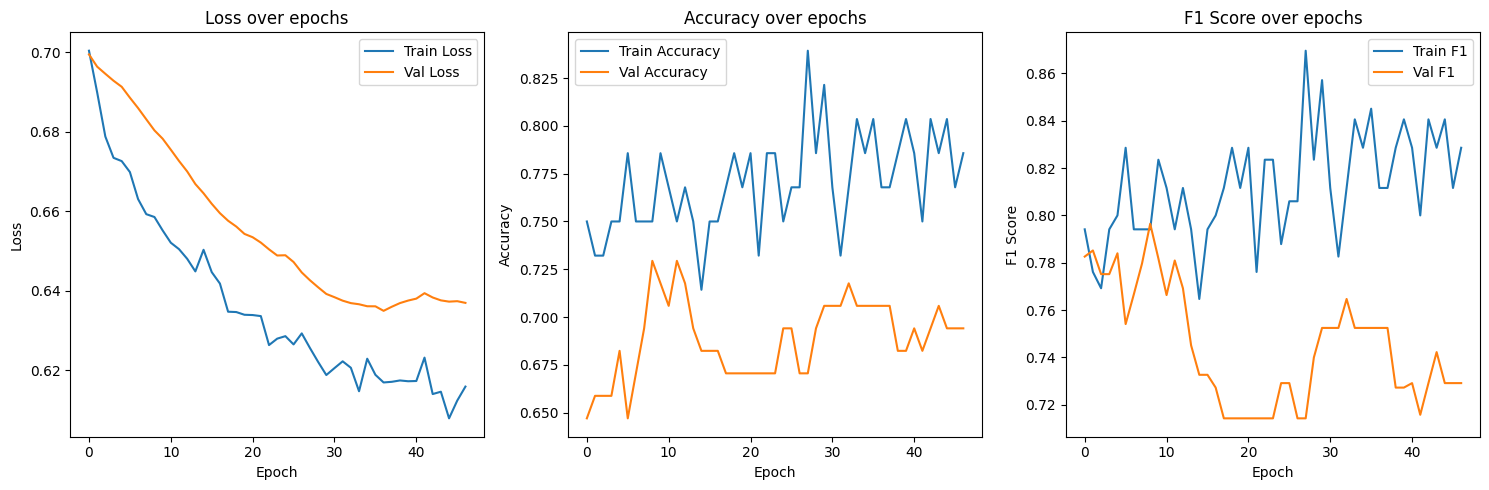

In [ ]:
batch_size = 32
train_loader, val_loader, test_loader = loader(mutag, batch_size=batch_size)
sage = GraphSAGE_Rewire(dim_h=128).to(device)
model = sage

# Training configuration
config = {
    'lr': 0.001,
    'weight_decay': 1e-3,
    'epochs': 100,
    'print_every': 5,
    'pos_weight': 1.2,  # Adjust based on class imbalance
    'use_wandb': False,  # Set to True if using wandb
    'early_stopping_patience': 10
}

# Train model
# model, train_metrics, val_metrics, best_metrics = train(
#     model,
#     train_loader,
#     val_loader,
#     config
# )
model, train_metrics, val_metrics, best_metrics = train(
    model,
    train_loader,
    val_loader,
    config,
    i=3,
    rewiring_edge_index=edge_index3
)

# Evaluate on test set
#test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(model, test_loader, nn.BCEWithLogitsLoss(), device)

test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(model, test_loader, nn.BCEWithLogitsLoss(), device, rewired_edge_index=edge_index3)

# Print best metrics from training, validation, and test sets
print("\nBest Training Metrics:")
print(f"Loss: {best_metrics['train']['loss']:.4f}, Accuracy: {best_metrics['train']['accuracy']:.4f}, F1: {best_metrics['train']['f1']:.4f}")

print("\nBest Validation Metrics:")
print(f"Loss: {best_metrics['val']['loss']:.4f}, Accuracy: {best_metrics['val']['accuracy']:.4f}, F1: {best_metrics['val']['f1']:.4f}")

print("\nTest Metrics:")
print(f"Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")

# Plot results
plot_training_metrics(train_metrics, val_metrics)


In [ ]:
#import torch
# import torch.nn as nn
# import numpy as np
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from sklearn.metrics import f1_score, precision_recall_fscore_support
# import wandb  # Optional for logging
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# class EarlyStopping:
#     def __init__(self, patience=10, min_delta=0.001):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.counter = 0
#         self.best_loss = None
#         self.early_stop = False

#     def __call__(self, val_loss):
#         if self.best_loss is None:
#             self.best_loss = val_loss
#         elif val_loss > self.best_loss - self.min_delta:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_loss = val_loss
#             self.counter = 0

# def train_epoch(model, loader, criterion, optimizer, device):
#     model.train()
#     total_loss = 0
#     predictions = []
#     labels = []

#     for data in loader:
#         data = data.to(device)
#         optimizer.zero_grad()

#         # Forward pass
#         out = model(data.x, data.edge_index, data.batch).squeeze()

#         # Calculate loss
#         loss = criterion(out, data.y.float())
#         loss.backward()

#         # Gradient clipping
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
#         optimizer.step()

#         # Store predictions and labels
#         pred = (out >= 0.5).float()
#         predictions.extend(pred.cpu().numpy())
#         labels.extend(data.y.cpu().numpy())

#         total_loss += loss.item() * data.num_graphs

#     # Calculate metrics
#     avg_loss = total_loss / len(loader.dataset)
#     accuracy = np.mean(np.array(predictions) == np.array(labels))
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

#     return avg_loss, accuracy, precision, recall, f1

# @torch.no_grad()
# def evaluate(model, loader, criterion, device):
#     model.eval()
#     total_loss = 0
#     predictions = []
#     labels = []

#     for data in loader:
#         data = data.to(device)

#         # Get model output and ensure correct shape
#         out = model(data.x, data.edge_index, data.batch).squeeze()

#         # Reshape output and target to match dimensions
#         if out.dim() == 0:  # Check if out is scalar
#             out = out.unsqueeze(0)
#         if data.y.dim() == 0:  # Check if target is scalar
#             data.y = data.y.unsqueeze(0)

#         # Compute loss
#         loss = criterion(out, data.y.float())
#         total_loss += loss.item() * data.num_graphs

#         # Binarize predictions
#         pred = (out >= 0.5).float()
#         predictions.extend(pred.cpu().numpy())
#         labels.extend(data.y.cpu().numpy())

#     avg_loss = total_loss / len(loader.dataset)
#     accuracy = np.mean(np.array(predictions) == np.array(labels))
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

#     return avg_loss, accuracy, precision, recall, f1


# def train(model, train_loader, val_loader, config):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = model.to(device)

#     # Initialize training components
#     criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([config['pos_weight']]).to(device))
#     optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
#     scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'])
#     early_stopping = EarlyStopping(patience=config['early_stopping_patience'])

#     # Training tracking
#     best_metrics = {
#         'train': {'f1': 0, 'loss': float('inf'), 'accuracy': 0},
#         'val': {'f1': 0, 'loss': float('inf'), 'accuracy': 0}
#     }
#     train_metrics, val_metrics = [], []

#     for epoch in tqdm(range(config['epochs'])):
#         # Training phase
#         train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(
#             model, train_loader, criterion, optimizer, device
#         )

#         # Validation phase
#         val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(
#             model, val_loader, criterion, device
#         )

#         # Scheduler step
#         scheduler.step()

#         # Early stopping check
#         early_stopping(val_loss)

#         # Save best model based on validation F1 score
#         if val_f1 > best_metrics['val']['f1']:
#             best_metrics['val'] = {
#                 'f1': val_f1, 'loss': val_loss, 'accuracy': val_acc
#             }
#             best_metrics['train'] = {
#                 'f1': train_f1, 'loss': train_loss, 'accuracy': train_acc
#             }
#             best_model_state = model.state_dict().copy()

#         # Store metrics for each epoch
#         train_metrics.append({'loss': train_loss, 'accuracy': train_acc, 'f1': train_f1})
#         val_metrics.append({'loss': val_loss, 'accuracy': val_acc, 'f1': val_f1})

#         # Optional: Log to wandb
#         if config['use_wandb']:
#             wandb.log({
#                 'train_loss': train_loss,
#                 'train_acc': train_acc,
#                 'train_f1': train_f1,
#                 'val_loss': val_loss,
#                 'val_acc': val_acc,
#                 'val_f1': val_f1,
#                 'learning_rate': optimizer.param_groups[0]['lr']
#             })

#         # Print metrics at intervals
#         if epoch % config['print_every'] == 0:
#             print(f'Epoch {epoch:03d}:')
#             print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
#             print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}')

#         if early_stopping.early_stop:
#             print("Early stopping triggered")
#             break

#     # Load best model
#     model.load_state_dict(best_model_state)
#     print("\nBest Train Metrics:", best_metrics['train'])
#     print("Best Validation Metrics:", best_metrics['val'])
#     return model, train_metrics, val_metrics, best_metrics

# def plot_training_metrics(train_metrics, val_metrics):
#     plt.figure(figsize=(15, 5))

#     # Plot loss
#     plt.subplot(1, 3, 1)
#     plt.plot([x['loss'] for x in train_metrics], label='Train Loss')
#     plt.plot([x['loss'] for x in val_metrics], label='Val Loss')
#     plt.title('Loss over epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Plot accuracy
#     plt.subplot(1, 3, 2)
#     plt.plot([x['accuracy'] for x in train_metrics], label='Train Accuracy')
#     plt.plot([x['accuracy'] for x in val_metrics], label='Val Accuracy')
#     plt.title('Accuracy over epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Plot F1 score
#     plt.subplot(1, 3, 3)
#     plt.plot([x['f1'] for x in train_metrics], label='Train F1')
#     plt.plot([x['f1'] for x in val_metrics], label='Val F1')
#     plt.title('F1 Score over epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('F1 Score')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

